In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TiDEModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TiDEModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=25,
        output_chunk_length=1,
        num_encoder_layers=3,
        num_decoder_layers=2,
        hidden_size=64,
        temporal_width_past=2,
        temporal_width_future=1,
        use_reversible_instance_norm=True,
        n_epochs=100,
        batch_size=88,
        dropout=0.21681024106774108,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.003388720125598311, "weight_decay": 0.0874880175491006e-06}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.010
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.009. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU c

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    2.526243    1.589416   1.214331  0.949529   
Precipitation_accumulated      0.004363    0.066050   0.019851  0.993059   
Humidity                      21.818914    4.671072   3.288888  0.930371   
Wind_Speed_kmh                 0.201266    0.448627   0.332438  0.523907   
Soil_Moisture              18626.987390  136.480722  56.930464  0.969885   
Soil_Temperature               4.842668    2.200606   1.550581  0.933282   
Wind_Dir_Sin                   0.262083    0.511941   0.386702  0.179883   
Wind_Dir_Cos                   0.239614    0.489503   0.343548  0.379265   

                               SMAPE  
Temperature                 7.596483  
Precipitation_accumulated   0.507739  
Humidity                    5.316520  
Wind_Speed_kmh             40.858436  
Soil_Moisture               0.

Metric val_loss improved. New best score: 0.056
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.048
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.046
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.029
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.025
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.025. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    2.827284    1.681453   1.073374  0.918676   
Precipitation_accumulated    168.473150   12.979721   1.562437  0.995774   
Humidity                      12.955538    3.599380   2.444365  0.897023   
Wind_Speed_kmh                 0.052370    0.228844   0.124287  0.840420   
Soil_Moisture              39753.036546  199.381635  90.736246  0.973562   
Soil_Temperature               4.074848    2.018625   1.170919  0.886354   
Wind_Dir_Sin                   0.113970    0.337595   0.188273  0.521093   
Wind_Dir_Cos                   0.165682    0.407040   0.210833  0.746606   

                                SMAPE  
Temperature                  7.658267  
Precipitation_accumulated    1.069420  
Humidity                     3.123813  
Wind_Speed_kmh             119.521235  
Soil_Moisture            

Metric val_loss improved. New best score: 0.000
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide b

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                  MSE       RMSE       MAE           R2  \
Temperature                  0.330790   0.575143  0.292554     0.940958   
Precipitation_accumulated    0.536822   0.732681  0.688865 -4500.106822   
Humidity                     1.305501   1.142585  0.718479     0.923952   
Wind_Speed_kmh               0.000054   0.007339  0.005490         -inf   
Soil_Moisture              113.678941  10.662033  8.013529     0.914790   
Soil_Temperature             0.529784   0.727863  0.337931     0.916559   
Wind_Dir_Sin                 0.000003   0.001746  0.001421         -inf   
Wind_Dir_Cos                 0.000002   0.001501  0.001200         -inf   

                                SMAPE  
Temperature                  2.057948  
Precipitation_accumulated    0.150231  
Humidity                     0.829971  
Wind_Speed_kmh             200.000000  
Soil_Moisture                0.126

Metric val_loss improved. New best score: 0.000
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide b

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.094345   0.307156   0.167005   0.833790   
Precipitation_accumulated     1.078362   1.038442   0.930563 -31.672556   
Humidity                      0.564290   0.751192   0.492648   0.941945   
Wind_Speed_kmh                0.000125   0.011197   0.009048       -inf   
Soil_Moisture              2292.128427  47.876178  20.014645   0.934504   
Soil_Temperature              0.029684   0.172289   0.097074   0.870417   
Wind_Dir_Sin                  0.000005   0.002173   0.001777       -inf   
Wind_Dir_Cos                  0.000010   0.003192   0.002619       -inf   

                                SMAPE  
Temperature                  1.791583  
Precipitation_accumulated    0.202773  
Humidity                     0.543791  
Wind_Speed_kmh             200.000000  
Soil_Moisture                0.338

Metric val_loss improved. New best score: 0.000
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                   0.270092   0.519703   0.246261  0.886362   
Precipitation_accumulated     0.935759   0.967347   0.912696 -2.300424   
Humidity                      1.150222   1.072484   0.625436  0.975437   
Wind_Speed_kmh                0.000532   0.023056   0.010437  0.743372   
Soil_Moisture              1143.669867  33.818188  14.116660  0.857327   
Soil_Temperature              0.011809   0.108670   0.070668  0.992721   
Wind_Dir_Sin                  0.009081   0.095292   0.027183  0.842444   
Wind_Dir_Cos                  0.015753   0.125510   0.029815  0.821166   

                                SMAPE  
Temperature                  3.481752  
Precipitation_accumulated    0.198660  
Humidity                     0.751545  
Wind_Speed_kmh             175.422412  
Soil_Moisture                0.246151  
Soi

Metric val_loss improved. New best score: 0.010
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.010. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    0.755339    0.869102   0.605458  0.919224   
Precipitation_accumulated      0.538859    0.734070   0.680419  0.535389   
Humidity                       7.230352    2.688931   1.537062  0.937385   
Wind_Speed_kmh                 0.486056    0.697177   0.475590  0.687516   
Soil_Moisture              24634.898696  156.955085  43.561804  0.980932   
Soil_Temperature               0.211423    0.459808   0.299059  0.957958   
Wind_Dir_Sin                   0.301718    0.549289   0.395935  0.369443   
Wind_Dir_Cos                   0.266647    0.516379   0.371173  0.451466   

                               SMAPE  
Temperature                22.707664  
Precipitation_accumulated   0.147263  
Humidity                    1.727932  
Wind_Speed_kmh             68.782135  
Soil_Moisture               0.

Metric val_loss improved. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                  MSE       RMSE        MAE        R2  \
Temperature                  1.556192   1.247474   0.973910  0.942480   
Precipitation_accumulated    0.722864   0.850214   0.811017 -1.383474   
Humidity                    12.676655   3.560429   2.666154  0.916289   
Wind_Speed_kmh               0.570383   0.755237   0.569170  0.525313   
Soil_Moisture              674.440002  25.969983  12.335027  0.886226   
Soil_Temperature             0.487621   0.698299   0.531563  0.956350   
Wind_Dir_Sin                 0.463343   0.680693   0.538859  0.137788   
Wind_Dir_Cos                 0.336957   0.580480   0.459931  0.006929   

                                SMAPE  
Temperature                 10.686043  
Precipitation_accumulated    0.173952  
Humidity                     3.264429  
Wind_Speed_kmh              56.174204  
Soil_Moisture                0.141542  
Soil_Tempera

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TiDEModel(output_chunk_shift=0, num_encoder_layers=3, num_decoder_layers=2, decoder_output_dim=16, hidden_size=64, temporal_width_past=2, temporal_width_future=1, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.21681024106774108, use_static_covariates=True, model_name=model_2, input_chunk_length=25, output_chunk_length=1, use_reversible_instance_norm=True, n_epochs=100, batch_size=88, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f2b33b07920>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


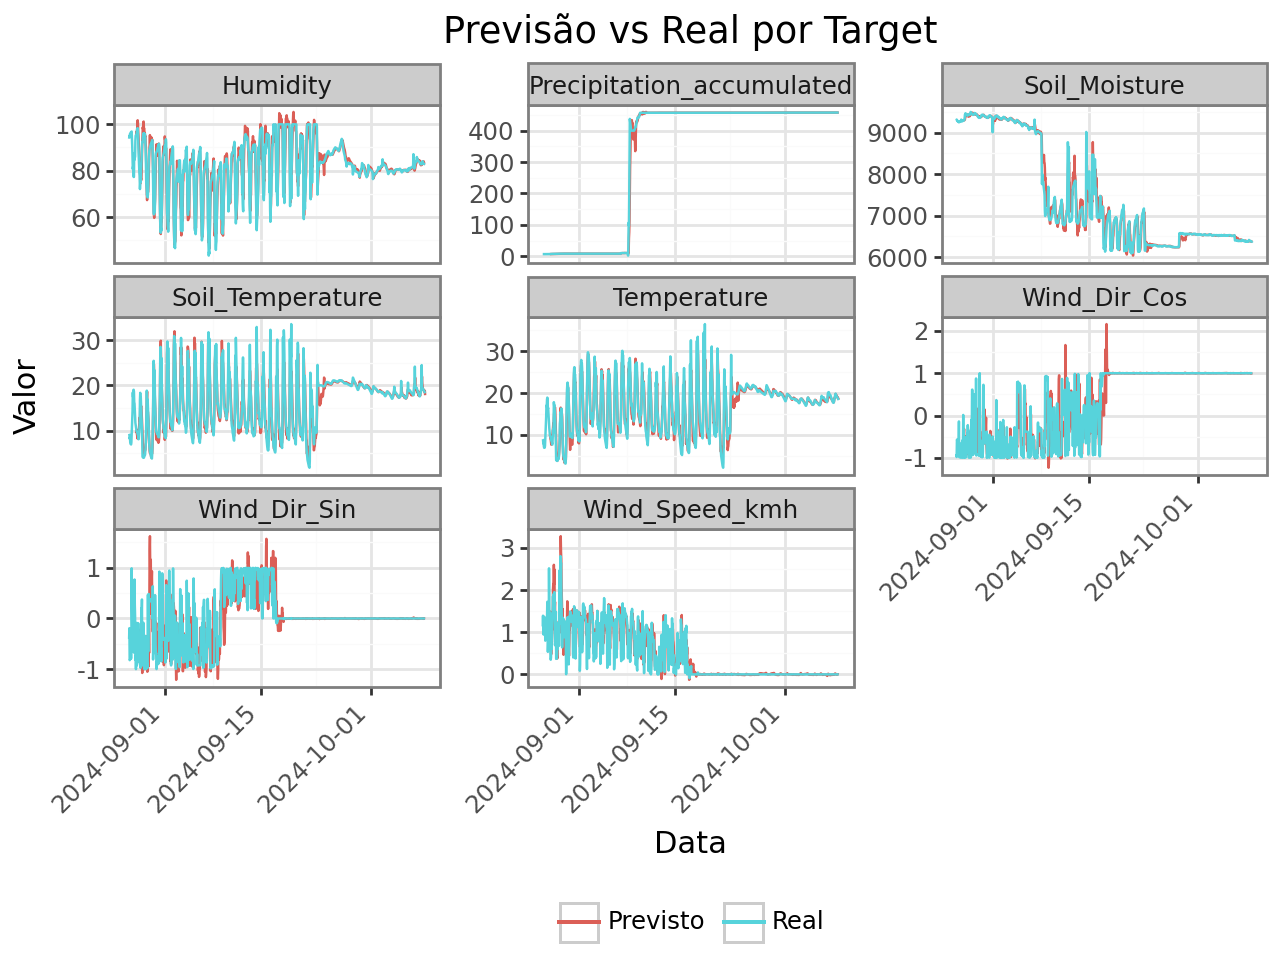

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

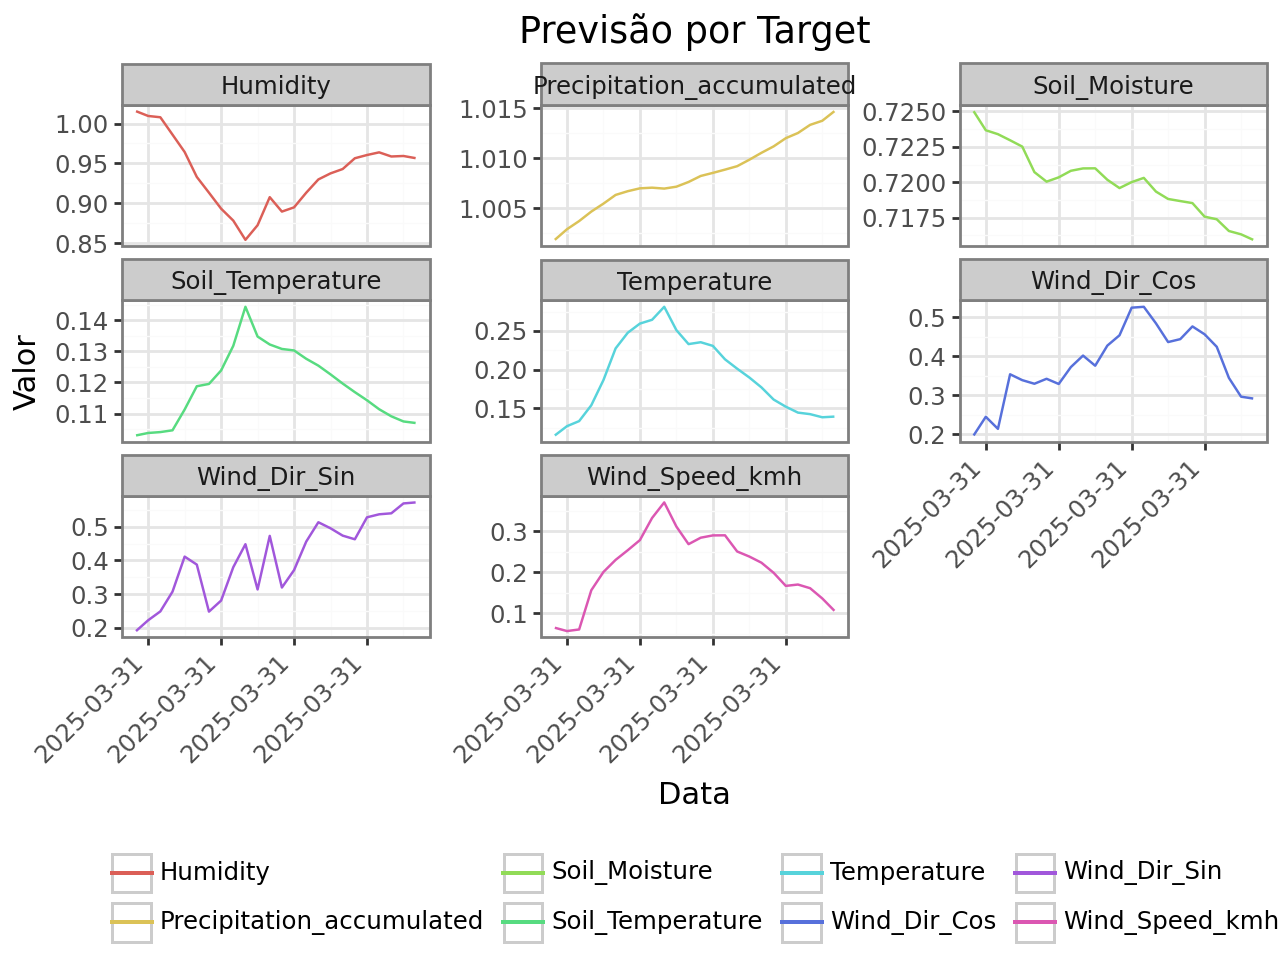

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)